In [13]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
import open3d as o3d  # type: ignore
from projection.projections import camera_to_image, world_to_camera, filter_pixel_points
from projection.utils import get_cameras, get_extrinsic_matrix, get_intrinsic_matrix 
from projection.utils import save_ply

In [15]:
# Read the point cloud
gaussian_file = './projection/point_cloud/iteration_30000/point_cloud.ply' 

In [16]:
pcd = o3d.io.read_point_cloud(gaussian_file)

In [17]:
print(np.asarray(pcd.points))

[[ -0.17732507   1.4564606   -0.61733437]
 [ -0.23953794  -0.25514811   1.35187292]
 [ -0.58748877  -0.38072723  -0.16701771]
 ...
 [ 14.64802265  -0.62514943 -26.57488251]
 [  0.2382715   -8.91827393  24.54455185]
 [-34.56573486  -8.37898922   3.83610821]]


In [18]:
pcd_array = np.asarray(pcd.points)
pcd_array = torch.from_numpy(pcd_array)
print(pcd_array)

tensor([[ -0.1773,   1.4565,  -0.6173],
        [ -0.2395,  -0.2551,   1.3519],
        [ -0.5875,  -0.3807,  -0.1670],
        ...,
        [ 14.6480,  -0.6251, -26.5749],
        [  0.2383,  -8.9183,  24.5446],
        [-34.5657,  -8.3790,   3.8361]], dtype=torch.float64)


In [19]:
# save_ply(pcd_array) 

### Converting World Coordinates to Pixel Coordinates

In [21]:
# Get Cameras 

cameras = get_cameras('./projection/cameras.json')  
i = 15
print('Image Name: ', cameras[i]['img_name'])

# WIDTH = cameras[i]['width'] 
# HEIGHT = cameras[i]['height'] 

WIDTH = cameras[i]['width'] 
HEIGHT = cameras[i]['height']

# Get Extrinsic & intrinsic Matrices for first camera 
extrinsic = get_extrinsic_matrix(cameras[i])  
intrinsic = get_intrinsic_matrix(cameras[i]) 

Image Name:  000121


In [22]:
# Convert to Camera Coordinates 
camera_coords = world_to_camera(pcd_array, extrinsic) 
print(camera_coords) 

tensor([[ -1.3128,   0.8392,  -0.6652,  ..., -26.3548,  24.8861,   3.1334],
        [  0.4786,  -0.9966,  -1.3347,  ...,  -2.5285,  -6.8881, -13.1983],
        [  5.4150,   5.3544,   5.6117,  ..., -10.7645,   4.8875,  38.4651]],
       dtype=torch.float64)


In [23]:
# Convert Camera Coordinates to Pixel Coordinates 
pixel_coords, points_depths, indices = camera_to_image(camera_coords, intrinsic) 
print(pixel_coords) 

tensor([[  696,  1160,   840,  ..., -4538,  6901,  1073],
        [  647,   330,   270,  ...,  -866, -1084,   148]], dtype=torch.int32)


In [24]:
points_depths

tensor([ 5.4150,  5.3544,  5.6117,  ..., 11.2614,  4.8875, 38.4651],
       dtype=torch.float64)

In [25]:
# Filter points outside the image width and height  

filt_points, filt_depths, filt_indices = filter_pixel_points(
    pixel_coords, points_depths, indices,  WIDTH, HEIGHT) 

In [26]:
print(filt_points) 
print(filt_indices)

tensor([[ 696, 1160,  840,  ..., 1334,  680, 1073],
        [ 647,  330,  270,  ...,  233,  264,  148]], dtype=torch.int32)
tensor([      0,       1,       2,  ..., 2541220, 2541221, 2541225])


In [27]:
img = torch.zeros((HEIGHT, WIDTH))  

x = filt_points[0, :].squeeze() 
y = filt_points[1, :].squeeze()   

img[y, x] = 1
print(img)

tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [28]:
from PIL import Image 

im = Image.fromarray((img.numpy()*255).astype(np.uint8), 'L')

name = 'output.png'
im.save(name) 

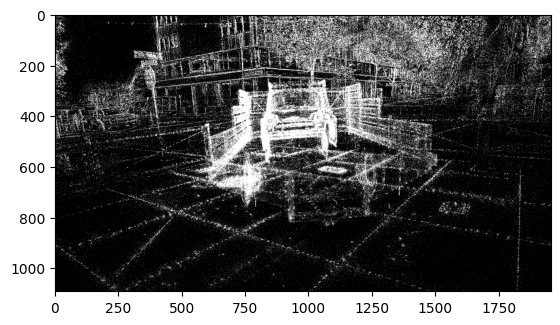

In [29]:
# Visualize grayscale projected view 

import matplotlib.pyplot as plt 

plt.imshow(img, cmap='gray') 
plt.show()

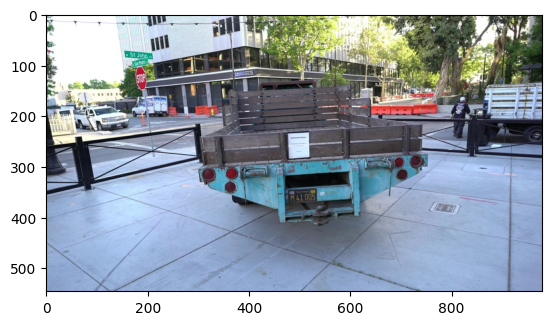

In [31]:
# place image dataset in the ../dataset directory
img_gt = plt.imread(f"./dataset/truck/images/{cameras[i]['img_name']}.jpg")
plt.imshow(img_gt)
plt.show()

### Extracting 3D gaussian for each user_point 

In [47]:
from projection.projections import get_3D_indices

In [48]:
user_points = torch.tensor([380,250]).unsqueeze(-1) 
user_points

tensor([[380],
        [250]])

In [49]:
# Hyperparameter 
eps = 1.2

pcd_indices = get_3D_indices(filt_points, filt_depths, 
                             filt_indices, user_points, eps)

gaussian_mappings = pcd_array[[pcd_indices], :] 

print(gaussian_mappings) 

tensor([[-2.7389, -0.3507, -3.3606]], dtype=torch.float64)


In [63]:
from sam.sam import SAM

sam = SAM("./sam/sam_vit_h_4b8939.pth")


Loading pth...DONE


In [89]:
def get_camera(i):
    print('Image Name: ', cameras[i]['img_name'])

    # Get Extrinsic & intrinsic Matrices for first camera 
    extrinsic = get_extrinsic_matrix(cameras[i])  
    intrinsic = get_intrinsic_matrix(cameras[i]) 

    image = plt.imread(f"./dataset/truck/images/{cameras[i]['img_name']}.jpg")

    return extrinsic, intrinsic, image

Image Name:  000185
[[632  73]]
(1,)
(1, 2)


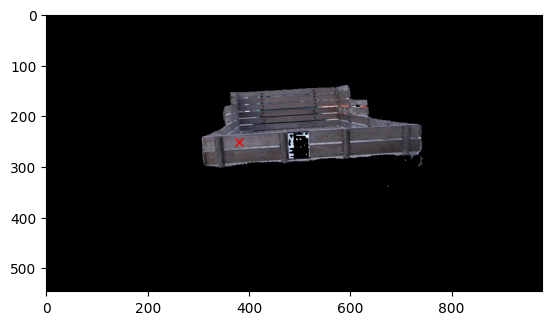

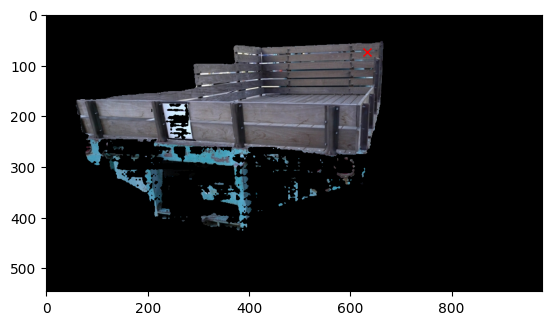

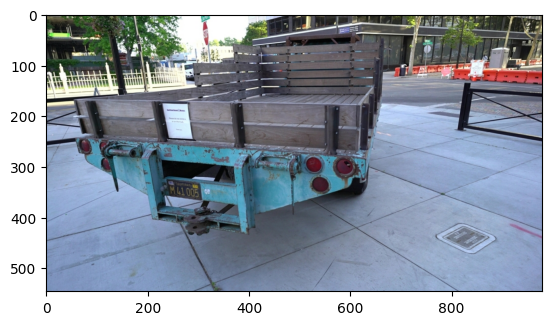

In [91]:
# get new view camera matrices
m_ex, m_in, img_view = get_camera(23)
prompt_cam = world_to_camera(gaussian_mappings, m_ex) 
prompt_2d, _, _ = camera_to_image(prompt_cam, m_in) 

input_points = prompt_2d.numpy().T
print(input_points)
input_labels = np.array([1])
print(input_labels.shape)
print(input_points.shape)

# draw reference pic (original input view)
mask_original, _, _ = sam.predict(img_gt, np.array([[380, 250]]), np.array([1]), multimask=False)
plt.imshow(mask_original[0][:,:,np.newaxis] * img_gt)
plt.plot(380, 250, 'rx')
plt.show()


# draw new view mask
mask_view, _, _ = sam.predict(img_view, input_points, input_labels, multimask=False)
plt.imshow(mask_view[0][:,:,np.newaxis] * img_view)
plt.plot(input_points[:,0], input_points[:,1], 'rx')
plt.show()

plt.imshow(img_view)
plt.show()